In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.0 MB/s eta 

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



-

hub://activeloop/nih-chest-xray-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for i, layer in enumerate(model.features):
    if i % 3 == 0:
        for param in layer.parameters():
            param.requires_grad = False

num_labels = 15
in_features = model.classifier.in_features

classifier = nn.Sequential(
    nn.Linear(in_features, 1000),
    nn.ReLU(),
    nn.Linear(1000, num_labels),
    nn.Sigmoid()
)


model.classifier = classifier

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = class_averaged_binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 92.5MB/s]


Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [01:12<00:00, 29.5MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1852
Validation phase completed. Average loss: 0.1781
Micro-averaged ROC AUC: 0.8933752600304357
Macro-averaged ROC AUC: 0.7280245932495044
ROC AUC for label 0: 0.7304031173994875
ROC AUC for label 1: 0.6822858467601715
ROC AUC for label 2: 0.6893705285966171
ROC AUC for label 3: 0.6070722692162399
ROC AUC for label 4: 0.656552534924207
ROC AUC for label 5: 0.7629612011821549
ROC AUC for label 6: 0.8146817438783936
ROC AUC for label 7: 0.8626680290765084
ROC AUC for label 8: 0.7066186341547666
ROC AUC for label 9: 0.7212933876859314
ROC AUC for label 10: 0.7657618707098535
ROC AUC for label 11: 0.7278424973725934
ROC AUC for label 12: 0.6916477651099794
ROC AUC for label 13: 0.6437357796499504
ROC AUC for label 14: 0.8574736930257127


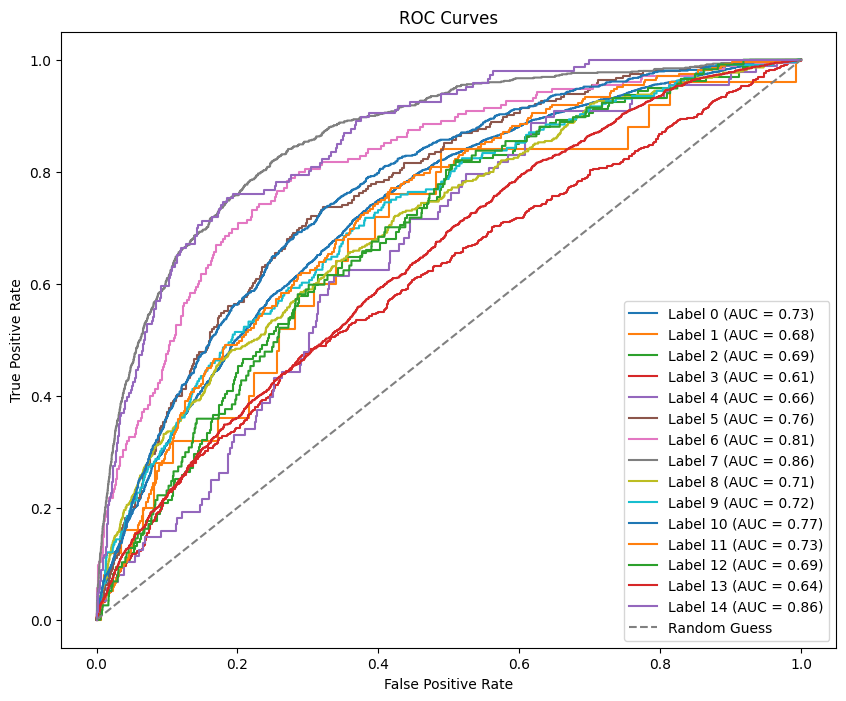

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1761
Validation phase completed. Average loss: 0.1743
Micro-averaged ROC AUC: 0.8991431703332099
Macro-averaged ROC AUC: 0.752261685848968
ROC AUC for label 0: 0.7391252062588889
ROC AUC for label 1: 0.7706224643560913
ROC AUC for label 2: 0.7085665072308901
ROC AUC for label 3: 0.6160892536171944
ROC AUC for label 4: 0.6948722984162031
ROC AUC for label 5: 0.7763340962822999
ROC AUC for label 6: 0.891102310453496
ROC AUC for label 7: 0.8641991518469302
ROC AUC for label 8: 0.7468157455871286
ROC AUC for label 9: 0.7128230203888098
ROC AUC for label 10: 0.7796902032248391
ROC AUC for label 11: 0.7223380418984955
ROC AUC for label 12: 0.7023477986571133
ROC AUC for label 13: 0.6741540036843824
ROC AUC for label 14: 0.8848451

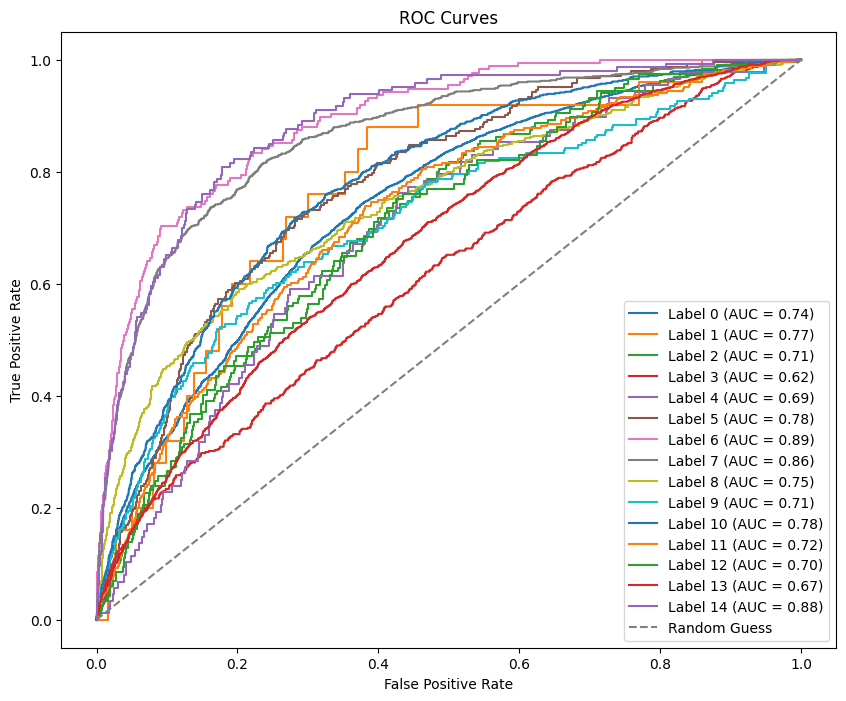

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1724
Validation phase completed. Average loss: 0.1712
Micro-averaged ROC AUC: 0.9048426182072973
Macro-averaged ROC AUC: 0.7736091095583931
ROC AUC for label 0: 0.7509138657570897
ROC AUC for label 1: 0.8035423669873654
ROC AUC for label 2: 0.7401789264855185
ROC AUC for label 3: 0.6559249449997229
ROC AUC for label 4: 0.6915085877457433
ROC AUC for label 5: 0.7973477368702062
ROC AUC for label 6: 0.907572422858491
ROC AUC for label 7: 0.8741745180449975
ROC AUC for label 8: 0.7938730088947158
ROC AUC for label 9: 0.7433189768716085
ROC AUC for label 10: 0.791351410578764
ROC AUC for label 11: 0.7622955366888116
ROC AUC for label 12: 0.7153881203090342
ROC AUC for label 13: 0.6809458344159954
ROC AUC for label 14: 0.8958003

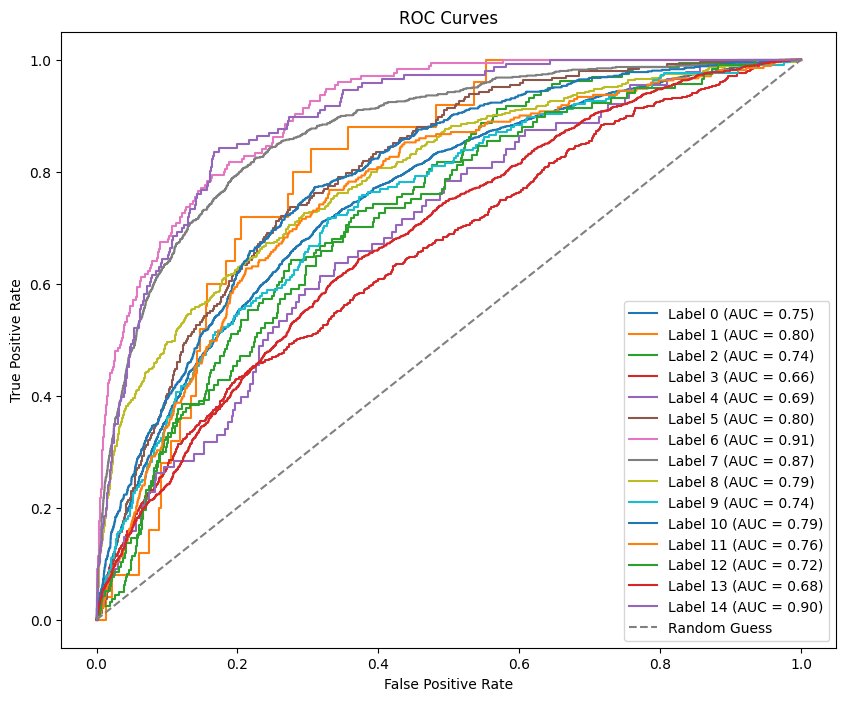

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1699
Validation phase completed. Average loss: 0.1705
Micro-averaged ROC AUC: 0.9062095357868939
Macro-averaged ROC AUC: 0.776961109043093
ROC AUC for label 0: 0.7529673711530716
ROC AUC for label 1: 0.813585255592906
ROC AUC for label 2: 0.7483336258420734
ROC AUC for label 3: 0.6394802853544471
ROC AUC for label 4: 0.7037692136215024
ROC AUC for label 5: 0.7904831537050985
ROC AUC for label 6: 0.9093891032878884
ROC AUC for label 7: 0.8738300078583113
ROC AUC for label 8: 0.7996094052282671
ROC AUC for label 9: 0.7664684970057777
ROC AUC for label 10: 0.7937471371561704
ROC AUC for label 11: 0.7624595432208945
ROC AUC for label 12: 0.7235195449606697
ROC AUC for label 13: 0.6828341948825062
ROC AUC for label 14: 0.8939402

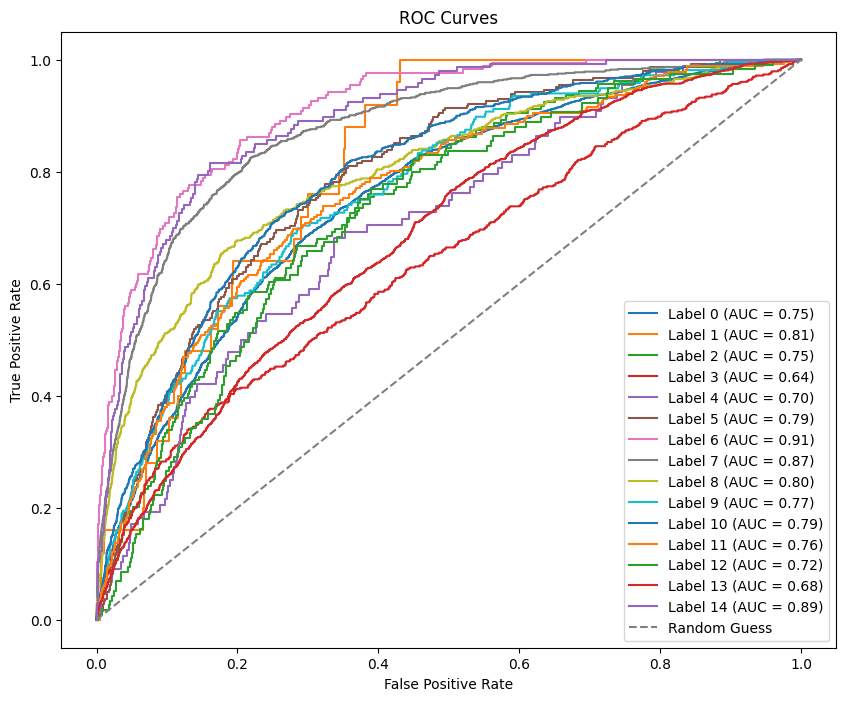

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1679
Validation phase completed. Average loss: 0.1682
Micro-averaged ROC AUC: 0.9089145911468463
Macro-averaged ROC AUC: 0.7885737748913745
ROC AUC for label 0: 0.7598770473875183
ROC AUC for label 1: 0.8565295004057031
ROC AUC for label 2: 0.7591679274163629
ROC AUC for label 3: 0.6730299326268345
ROC AUC for label 4: 0.7207881300157106
ROC AUC for label 5: 0.8009833673210214
ROC AUC for label 6: 0.9130703247442661
ROC AUC for label 7: 0.881814778314691
ROC AUC for label 8: 0.8061510475487661
ROC AUC for label 9: 0.7639695616669301
ROC AUC for label 10: 0.796493160480727
ROC AUC for label 11: 0.7707406623046067
ROC AUC for label 12: 0.7464377450317696
ROC AUC for label 13: 0.6883799231976173
ROC AUC for label 14: 0.8911735

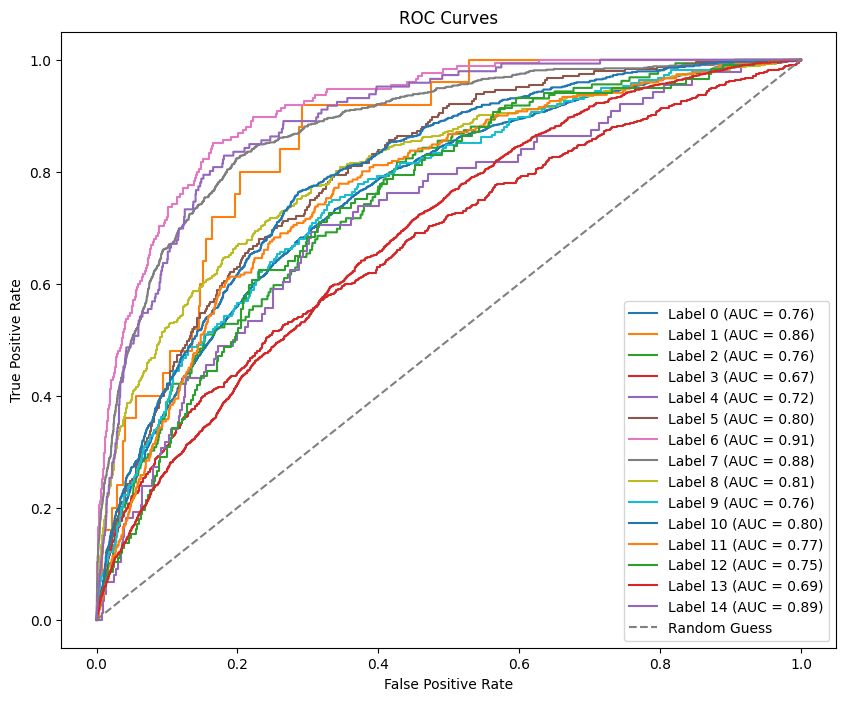

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_5.pt
------------------ Training Epoch 6 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1662
Validation phase completed. Average loss: 0.1676
Micro-averaged ROC AUC: 0.9104532597749949
Macro-averaged ROC AUC: 0.7923737638538169
ROC AUC for label 0: 0.7581929373726756
ROC AUC for label 1: 0.8415857192535064
ROC AUC for label 2: 0.7825497431477051
ROC AUC for label 3: 0.6786498513189515
ROC AUC for label 4: 0.7504863116215872
ROC AUC for label 5: 0.7993414854846389
ROC AUC for label 6: 0.9059980788351675
ROC AUC for label 7: 0.8859988186061217
ROC AUC for label 8: 0.8093780596263346
ROC AUC for label 9: 0.7643262780324184
ROC AUC for label 10: 0.8025914709497558
ROC AUC for label 11: 0.764905772193386
ROC AUC for label 12: 0.751158377520416
ROC AUC for label 13: 0.6926083432438555
ROC AUC for label 14: 0.8978352

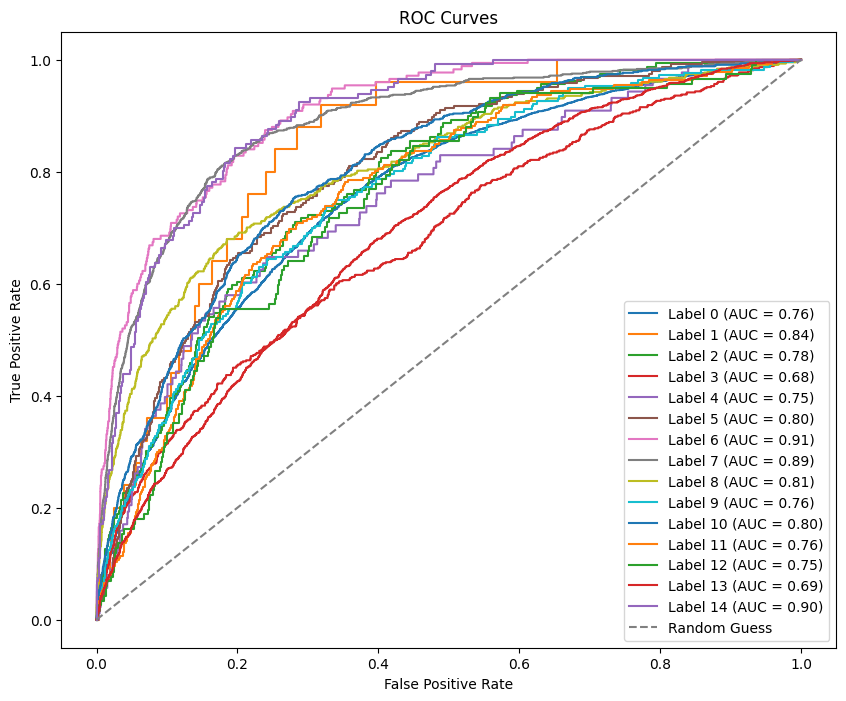

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_6.pt
------------------ Training Epoch 7 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1648
Validation phase completed. Average loss: 0.1677
Micro-averaged ROC AUC: 0.911133651066305
Macro-averaged ROC AUC: 0.7955020614376038
ROC AUC for label 0: 0.7578960163753948
ROC AUC for label 1: 0.8547629535180248
ROC AUC for label 2: 0.7786108722906842
ROC AUC for label 3: 0.6917099677175563
ROC AUC for label 4: 0.7452616130949853
ROC AUC for label 5: 0.7941178053887982
ROC AUC for label 6: 0.9131990764926945
ROC AUC for label 7: 0.8863005959156446
ROC AUC for label 8: 0.8188713827015666
ROC AUC for label 9: 0.7574652503380572
ROC AUC for label 10: 0.8042192139248723
ROC AUC for label 11: 0.7822367497031371
ROC AUC for label 12: 0.7497584105668464
ROC AUC for label 13: 0.7000603375906937
ROC AUC for label 14: 0.898060

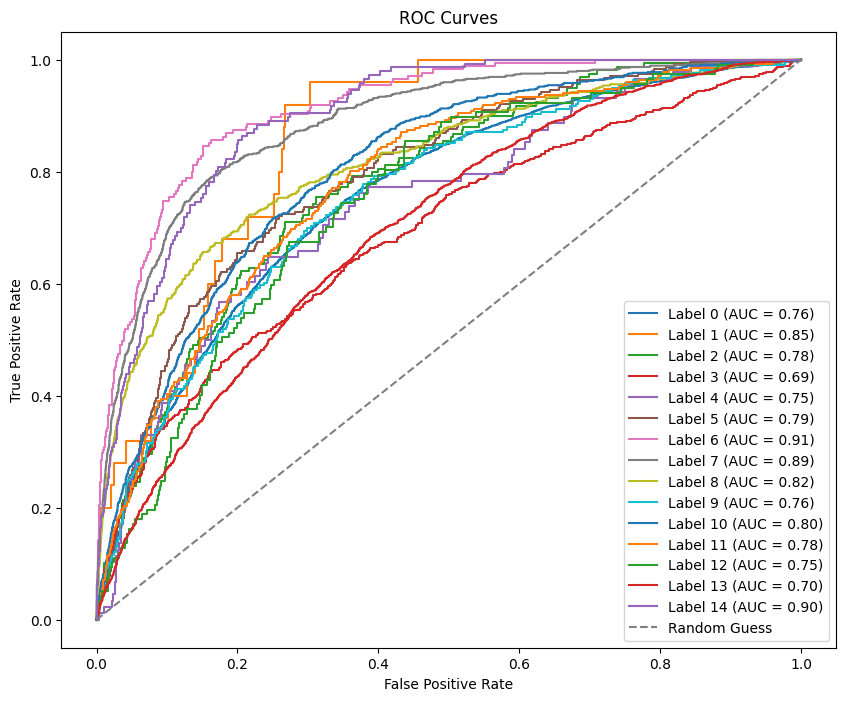

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_7.pt
------------------ Training Epoch 8 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1634
Validation phase completed. Average loss: 0.1689
Micro-averaged ROC AUC: 0.9106763227643447
Macro-averaged ROC AUC: 0.7935978601397942
ROC AUC for label 0: 0.7594520173400978
ROC AUC for label 1: 0.86364205401646
ROC AUC for label 2: 0.7883310488030467
ROC AUC for label 3: 0.6947328668948074
ROC AUC for label 4: 0.7381347925778099
ROC AUC for label 5: 0.7949274904851602
ROC AUC for label 6: 0.9136116213620047
ROC AUC for label 7: 0.8853008734902625
ROC AUC for label 8: 0.8168757913672695
ROC AUC for label 9: 0.7528238216286463
ROC AUC for label 10: 0.8013456601759064
ROC AUC for label 11: 0.7633220634795537
ROC AUC for label 12: 0.7384745567522369
ROC AUC for label 13: 0.6960429845995483
ROC AUC for label 14: 0.8969502

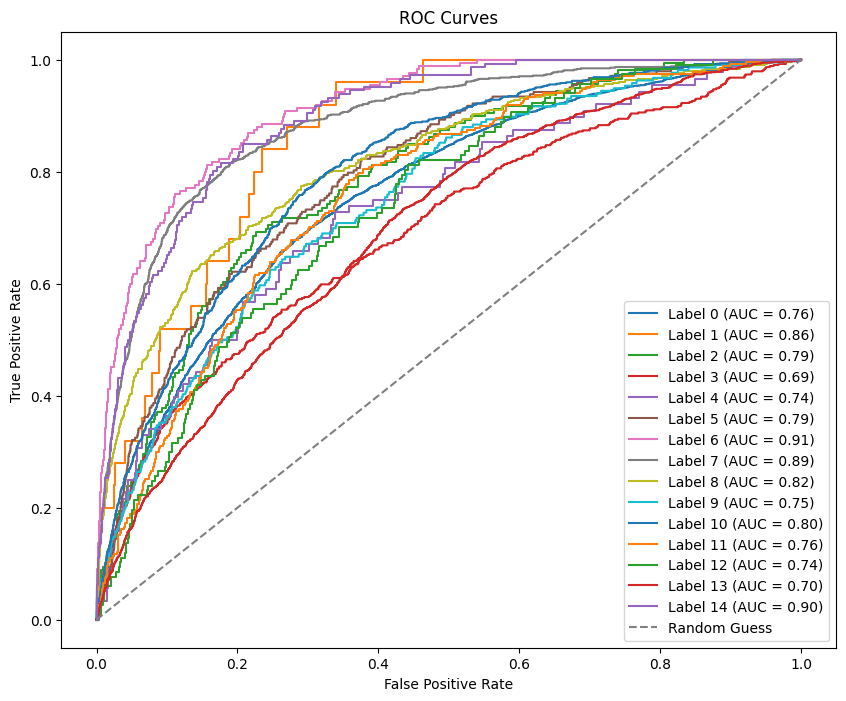

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_8.pt
------------------ Training Epoch 9 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1621
Validation phase completed. Average loss: 0.1689
Micro-averaged ROC AUC: 0.9087809222240195
Macro-averaged ROC AUC: 0.7918374842766231
ROC AUC for label 0: 0.7575238282003718
ROC AUC for label 1: 0.8415903558595108
ROC AUC for label 2: 0.7688336750872157
ROC AUC for label 3: 0.6907072431544453
ROC AUC for label 4: 0.7459993736996304
ROC AUC for label 5: 0.7952321317498839
ROC AUC for label 6: 0.912835740406815
ROC AUC for label 7: 0.8855776917741858
ROC AUC for label 8: 0.8091258594991548
ROC AUC for label 9: 0.7601526965562053
ROC AUC for label 10: 0.7978970661411666
ROC AUC for label 11: 0.7664102294286276
ROC AUC for label 12: 0.7573300487184494
ROC AUC for label 13: 0.6961123166136995
ROC AUC for label 14: 0.892234

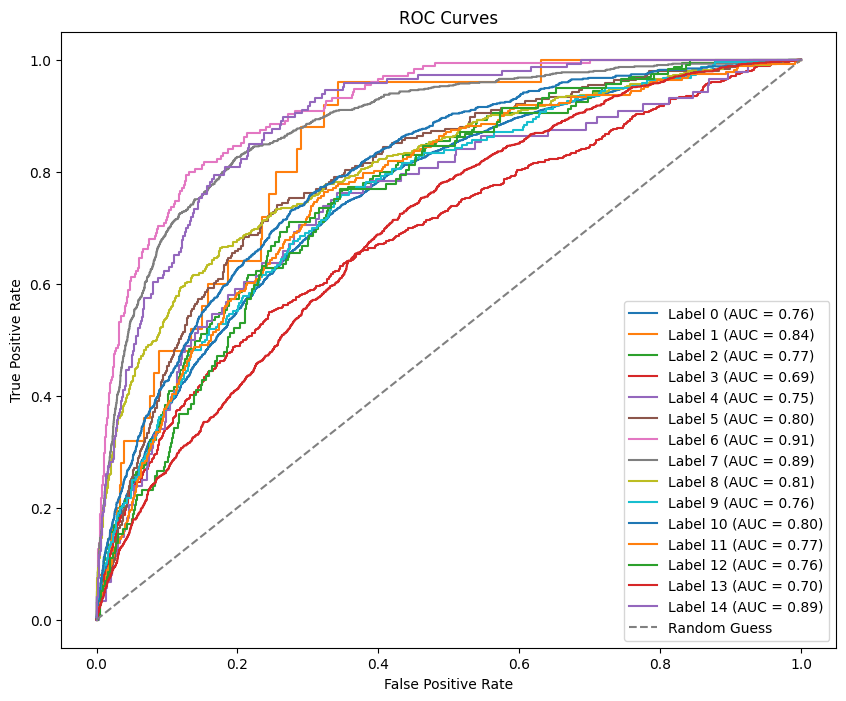

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_9.pt
------------------ Training Epoch 10 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1607
Validation phase completed. Average loss: 0.1686
Micro-averaged ROC AUC: 0.9089255557199297
Macro-averaged ROC AUC: 0.7922658417225515
ROC AUC for label 0: 0.7612666697304445
ROC AUC for label 1: 0.8183470499594296
ROC AUC for label 2: 0.8037540349544242
ROC AUC for label 3: 0.6833959804287829
ROC AUC for label 4: 0.7497253301346014
ROC AUC for label 5: 0.8020795864904691
ROC AUC for label 6: 0.902346180420971
ROC AUC for label 7: 0.8867506147105471
ROC AUC for label 8: 0.8066180173228824
ROC AUC for label 9: 0.7498057267794109
ROC AUC for label 10: 0.7975480875379378
ROC AUC for label 11: 0.7769436315052806
ROC AUC for label 12: 0.754306801055483
ROC AUC for label 13: 0.697715229057984
ROC AUC for label 14: 0.8933846

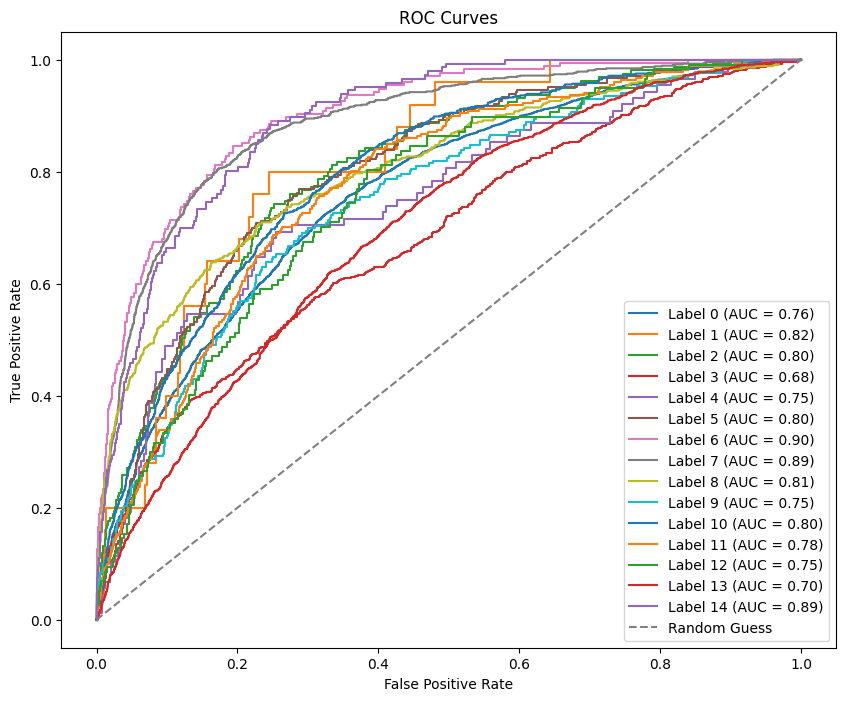

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_DenseNet121_checkpoint_epoch_10.pt


In [ ]:
num_epochs = 10
model_name = "SSN_DenseNet121"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_DenseNet121.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)